This script imports two seperate pretrained xgboost models that were trained on the FEMA's NFIP claims dataset and predicts damage distributions from a category 3 or higher hurricane passing within 30 miles (or 60 miles) of each household in the survey data

In [16]:
import pandas as pd
import numpy as np
import pickle
import os
import random
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


# code below creates a progres bar that can be deployed in any code chunk
import time, sys
from IPython.display import clear_output

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)





In [2]:
# get/change working directory
os.chdir("/home/dylan/Dropbox/Research/Hurricane Damage Predictions")
print(os.getcwd())

/home/dylan/Dropbox/Research/Hurricane Damage Predictions


In [3]:
# load pre trained xgboost model for nfip model
file_xgb = open('./Saved Python Objects/XGB_Trained.obj', 'rb') 
xgb_trained = pickle.load(file_xgb)
print(xgb_trained)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.03, max_delta_step=0, max_depth=10,
             min_child_weight=9, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=25, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.6,
             tree_method='exact', validate_parameters=1, verbosity=None)


In [4]:
# load cleaned survey data
# this is the data to add damage predictions to
make_data = 1 # if one, will generate fake data to play around with
               # if zero, will load specified csv file

if make_data == 0:
    survey_data = pd.DataFrame(pd.read_csv("./Data/cleaned_survey_data.csv"))
    survey_data.info() # inspect variables and types
    
    # clean data and label to be consistent with what cleaned xgboost model expects

if make_data == 1:
    # create some fake data that needs predictions. Actual data can be substituted here.
    obs = 5 # number of observations to generate

    # closest that storm was to county in which home is located
    storm_dist = np.random.uniform(low= .5, high=30, size= obs) # this will get replaced during the monte carlo reps
    fake_data = pd.DataFrame(storm_dist, columns = ['storm_dist']) 
    # total precipitation in county in which home is located on the day that storm was closest, 
    # along with the 2 days before and 2 days after closest approach
    fake_data['tot_precip'] = np.random.uniform(low=0, high=6, size= obs) # this will get replaced during the monte carlo reps

    # highest sustained one minute wind speed in m/s 
    fake_data['vmax_sust'] =np.random.uniform(low=20, high=60, size= obs) # this will get replaced during the monte carlo reps

    # highest gust wind speed  in m/s
    fake_data['vmax_gust'] =np.random.uniform(low=20, high=60, size= obs)  # this will get replaced during the monte carlo reps

    # longest continuous duration (in minutes) at which wind speed was above 20m/s
    fake_data['sust_dur'] = np.random.uniform(low=0, high=3, size= obs)  # this will get replaced during the monte carlo reps

    # = 1 if state home is located in is touching coast
    fake_data['coastal_state'] =np.random.uniform(low=0, high=1, size= obs) 

    # = 1 if county home is located in is touching coast
    fake_data['coastal_county'] = np.random.uniform(low=0, high=1, size= obs) 

    # = 1 if nfip claim = nfip coverage. This is used in the training data to let the ML algorithm 
    # know that the actual damage may be higher than reported. This can be set to 0.
    fake_data['total_flood_damage_censored'] = np.zeros(obs)
    
    # freeboard in feet   
    fake_data['freeboard_ft'] = np.random.uniform(low=-2, high=10, size= obs) 

    # base flood elevation in feet
    fake_data['base_flood_elv_ft'] = np.random.uniform(low=-2, high=5, size= obs) 

    # = 1 if home has a below ground basement
    fake_data['basement'] = np.random.uniform(low=0, high=1, size= obs) 

    # = 1 if home has a crawlspace
    fake_data['crawlspace'] = np.random.uniform(low=0, high=1, size= obs) 

    # = 1 if home is elevated (on pillars)
    fake_data['elevated_building'] = np.random.uniform(low=0, high=1, size= obs) 

    # =1 if FEMA flood zone clasifcation starts with A
    fake_data['a_zone'] = np.random.uniform(low=0, high=1, size= obs) 

    # =1 if FEMA flood zone clasifcation starts with V
    fake_data['v_zone'] = np.random.uniform(low=0, high=1, size= obs) 

    # =1 if FEMA flood zone clasifcation starts with X
    fake_data['x_zone'] = np.random.uniform(low=0, high=1, size= obs) 

    # =1 if home is is FEMA SFHA (special flood hazard area, zones A and V)
    fake_data['sfha'] = np.random.uniform(low=0, high=1, size= obs) 

    # number of floors in the home
    fake_data['floors'] = np.random.uniform(low=1, high=3, size= obs) 

    # = 1 if home was built after flood insurance rate maps went in to effect
    fake_data['post_firm'] = np.random.uniform(low=0, high=1, size= obs) 

    # = 1 if home is primary place of residence
    fake_data['primary_res'] = np.random.uniform(low=0, high=1, size= obs) 

    # avg county home value in the county home is located in
    fake_data['avg_county_home_value'] = np.random.uniform(low=100000, high=500000, size= obs) 

    # home value is assumed to be equal to flood insurance coverage on structure
    # in the nfip training data this should be set to the actual home value
    fake_data['assumed_home_value'] = np.random.uniform(low=100000, high=500000, size= obs) 

    # = 1 if nfip coverage equals $250,000 (the max nfip structure coverage), this 
    # will be zero if actual home value data is being used
    fake_data['assumed_home_value_censored'] = np.zeros(obs)
    
    # region dummy variables 
    fake_data['region_Atlantic'] = np.random.uniform(low=0, high=1, size= obs) 
    fake_data['region_Gulf of Mexico'] = np.random.uniform(low=0, high=1, size= obs) 
    fake_data['region_Pacific'] = np.zeros(obs)+1

    # = 1 if the observation needs a prediction. This data does not need damage predictions
    # this column will be used later to tell nfip data and fake data/ loaded data apart
    fake_data['get_prediction'] = np.zeros(obs)+1


#x = data[["storm_dist","tot_precip","vmax_sust","vmax_gust",
 #             "sust_dur","coastal_state","coastal_county",
 #             "total_flood_damage_censored","freeboard_ft",
 #             "base_flood_elv_ft","basement","crawlspace","elevated_building",
 #             "a_zone","v_zone","x_zone","sfha","floors","post_firm",
 #             "primary_res","avg_county_home_value","assumed_home_value",
 #             "assumed_home_value_censored"]]

In [5]:
# load nfip data
# this gets used again to draw random combinations of plausible hurricane conditions
nfip_data = pd.DataFrame(pd.read_csv("./Data/nfip_data_cleaned.csv"))
#nfip_data.info() # inspect variables and types

# select only columns that need to be passed to the xgboost model
nfip_subset = nfip_data[["storm_dist","tot_precip","vmax_sust","vmax_gust",
              "sust_dur","coastal_state","coastal_county",
             "total_flood_damage_censored","freeboard_ft",
              "base_flood_elv_ft","basement","crawlspace","elevated_building",
             "a_zone","v_zone","x_zone","sfha","floors","post_firm",
             "primary_res","avg_county_home_value","assumed_home_value",
              "assumed_home_value_censored"]]

# one hot encode categorical features
region = pd.get_dummies(nfip_data.coastal_region, prefix='region')
nfip_subset = nfip_subset.join(region)

# clean the subset
# drop rows with missing values
nfip_subset.dropna( inplace = True)

# = 1 if the observation needs a prediction. This data does not need damage predictions
# this column will be used later to tell nfip data and fake data/ loaded data apart
nfip_subset.loc[:,'get_prediction'] = 0



In [7]:
# load ihp data
# this gets used again to draw random combinations of plausible hurricane conditions

# NOTE: coming soon

In [8]:
# combine fake data / data that needs predictions with the nfip subset
nfip_combined = nfip_subset.append(fake_data)



7731988.000000002
6727667.375277677
6107008.9713374
5665648.516295302
5278851.76638459
5028117.724331138
4779061.483659172
4538271.699694445
4360931.844287218


Text(0, 0.5, 'Within Cluster SSE')

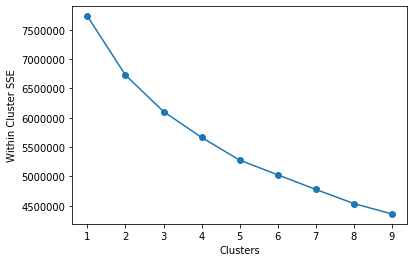

In [9]:
# apply k means clustering to create clusters of like data to randomly draw hurricane conditions from
# exclude hurricane variables when clustering
hurricane_vars = ['storm_dist','tot_precip','vmax_sust','vmax_gust','sust_dur']

# Scale the test data before trying to cluster
scaler = StandardScaler()
nfip_combined_scaled = scaler.fit_transform(nfip_combined.drop(hurricane_vars, axis = 1))


# decide how many clusters to use based on "elbow method"
distortion = [] # i.e. within cluster sse

max_clusters = 10 # define max number of clusters to consider
for k in range(1,max_clusters): 
    km = KMeans(
        n_clusters=k, init='random',
        n_init=20, max_iter=500,
        tol=0.001, random_state=0
    )
    km.fit(nfip_combined_scaled)
    distortion.append(km.inertia_)
    print('Clusters = ', k ,' , Distortion = ',km.inertia_)
# plot
plt.plot(range(1, max_clusters), distortion, marker='o')
plt.xlabel('Clusters')
plt.ylabel('Within Cluster SSE')

In [12]:
# Pick the number of clusters to use
clusters = 5

# cluster using K means choosen number of clusters
km = KMeans(
    n_clusters=clusters, init='random',
    n_init=20, max_iter=500, 
    tol=1e-04, random_state=0
)
clusters = km.fit_predict(nfip_combined_scaled)

# add the cluster number to the unscaled test data data
nfip_combined['cluster'] = clusters

# check and make sure cluster column has been added 
nfip_combined['cluster'].head()

1     3
6     0
8     4
10    4
11    3
Name: cluster, dtype: int32

In [13]:
# load pre trained xgboost model for nfip model
file_xgb = open('./Saved Python Objects/XGB_Trained.obj', 'rb') 
xgb_trained = pickle.load(file_xgb)
print(xgb_trained)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.03, max_delta_step=0, max_depth=10,
             min_child_weight=9, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=25, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.6,
             tree_method='exact', validate_parameters=1, verbosity=None)


In [31]:
# pull out the origonal data loaded/generated that needs to have damage predictiosn added to it
# this data now has a cluster assigned to each observation that corresponds to a set of observations
# in the nfip data. 
needs_predictions = nfip_combined[nfip_combined.get_prediction == 1]

# similarly, slice the combined data frame to pull out nfip data which does not need a prediction asigned to it
# again this data has a cluster number assinged to each observation
nfip_with_cluster = nfip_combined[nfip_combined.get_prediction == 0]

for k in range(len(needs_predictions)-1): # iterate over each row of the data frame that needs predictions added
    ooi = needs_predictions[k:k+1] # select a single observation (ooi = "observation of interest")
    trained_on_features = ooi.columns # store column names to slice with later

    # identify which cluster the observation belongs to
    ooi_cluster = int(ooi['cluster'])

    # extract historical hurricane conditions from all observations in the nfip data that 
    # have the same cluster number as the observation getting a prediction assinged to it
    hurricane_conditions = nfip_with_cluster[nfip_with_cluster.cluster.eq(ooi_cluster)] # filter based on cluster number
    hurricane_conditions = hurricane_conditions[hurricane_vars] # keep only variables related to hurricane conditions
    hurricane_conditions = hurricane_conditions.dropna() # drop any missing values

    # reps used to form the predicted damage distribution
    # will need to adjust based on number of observations: 
    # higher reps makes a nice smooth distribution, but increases computational cost
    reps = 5000 
    
    counter = 0 # counter for while loop
    damage_estimates = np.array([]) # initialize an array to store the damage estimates
    while counter < reps:
        counter = counter + 1
        # for each column in the selected observation related to the historical hurricane condition, 
        # replace it by randomly drawing values from the hurricane conditions identified above
        random_row = random.randint(1,len(hurricane_conditions)-1) # pick a random integer less than the number of rows in the hurricane conditions
        random_conditions = hurricane_conditions[random_row:random_row+1] # pick out a set of random conditions.
        
        # Note: its important not to mix conditions from different observations since
        # the conditions set of conditions need to be reasonable as a whole 
        # (for example: mixing observations may lead to peak wind gust speed being lower than sustained wind speed)
        
        # to generate more variation, perturb each observation by up to +/- 5 percent
        for t in range(len(random_conditions.columns)):
            disturbance = 1+random.uniform(-.05, .05)
            random_conditions[random_conditions.columns[t]] = random_conditions[random_conditions.columns[t]] * disturbance
        
   
        # replace the random hurricane conditions in the ooi with these randomly selected conditions
        ooi.loc[:,'storm_dist'] = float(random_conditions.loc[:,'storm_dist'])
        ooi.loc[:,'tot_precip'] = float(random_conditions.loc[:,'tot_precip'])
        ooi.loc[:,'vmax_sust'] = float(random_conditions.loc[:,'vmax_sust'])
        ooi.loc[:,'vmax_gust'] = float(random_conditions.loc[:,'vmax_gust'])
        ooi.loc[:,'sust_dur'] = float(random_conditions.loc[:,'sust_dur'])


        # predict damages using the trained XGB model and randomly selected conditions
        predicted_damage  = xgb_trained.predict(ooi[trained_on_features].drop(['cluster','get_prediction', 'region_Pacific'],axis = 1))
        if predicted_damage < 0:
            predicted_damage = 0
        # add predicted damage to the damage estimates array
        damage_estimates = np.append(damage_estimates,predicted_damage)

    # for first itteration create a df to save everything int
    if k == 0:
        predictions =  pd.DataFrame(ooi) # store the observation of interest as a df
        predictions['predicted_dam_dist'] = [damage_estimates] # store np.array of damage estimates in a single cell of the df
        # loop through range to calculate percentiles of the predicted damage distribution and add as columns to the df
        for p in range(0,100,5): 
            predictions['pct'] = np.percentile(damage_estimates,p)
            col_name = ["pred_dam",str(p),"pct"] 
            predictions.rename(columns={'pct':"_".join(col_name)}, inplace=True)
            
    # for subsequent itterations add to the existing df
    if k != 0:
        ooi_df = pd.DataFrame(ooi)
        ooi_df['predicted_dam_dist'] = [damage_estimates]
        for p in range(0,100,5):
            col_name = ["pred_dam",str(p),"pct"]
            ooi_df['pct'] = np.percentile(damage_estimates,p)
            ooi_df.rename(columns={'pct':"_".join(col_name)}, inplace=True)
            
    # append the current observation to the data frame of observations that already have damage estimates 
        predictions = predictions.append(ooi_df)
    
     # loop progress bar
    update_progress(k / len(needs_predictions))

update_progress(1)

Progress: [####################] 100.0%


In [34]:
# save data with predicted damage distributions to a csv file
predictions.to_csv('./Data/fake_data_with_predictions.csv', index=False)  


1


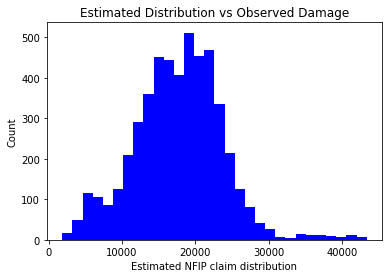

In [47]:
# plot a random observations estimated damage distribution
row = random.randint(0,len(predictions)-1)
print(row)
random_obs = predictions[row:row+1]

predicted = np.array(random_obs['predicted_dam_dist'])

hist = plt.hist(predicted, bins = 30, color='b')
plt.xlabel('Estimated NFIP claim distribution')
plt.ylabel('Count')
plt.title('Estimated Distribution vs Observed Damage')
plt.show()

In [41]:
# slice data frame to create a subset of the main data set that contains variables that need to be passed to the XGBoost model
xgb_features = pd.DataFrame(data['fsid'])
xgb_features['storm_dist'] = 1 # will randomly alter this in montecarlo simulation
xgb_features['tot_precip'] = 1 # will randomly alter this in montecarlo simulation
xgb_features['vmax_sust'] = 1 # will randomly alter this in montecarlo simulation
xgb_features['vmax_gust'] = 1 # will randomly alter this in montecarlo simulation
xgb_features['sust_dur'] = 1 # will randomly alter this in montecarlo simulation
xgb_features['coastal_state'] = 1 # all observations in this data set are from coastal states
xgb_features['coastal_county'] = 1 # all observations in this data set are from coastal counties
xgb_features['total_flood_damage_censored'] = 0
#xgb_features['freeboard_ft'] = data['above_bfe']  
xgb_features['base_flood_elv_ft'] = data['depth_2020_rp100_mid']*



#x = data[["storm_dist","tot_precip","vmax_sust","vmax_gust",
 #             "sust_dur","coastal_state","coastal_county",
 #             "total_flood_damage_censored","freeboard_ft",
 #             "base_flood_elv_ft","basement","crawlspace","elevated_building",
 #             "a_zone","v_zone","x_zone","sfha","floors","post_firm",
 #             "primary_res","avg_county_home_value","assumed_home_value",
 #             "assumed_home_value_censored"]]
